In [6]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

import src.data.Dataset as dt

In [2]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [ ]:
threshold = float(0.2)

OUTPUT_PATH = os.path.abspath("./logs/MegaDetector")
MODEL_PATH = os.path.abspath("./models/MegaDetector/md_v5a.0.0.pt")


DATASET_PATH = os.path.abspath("./dataset/datasetFiltered")
CSV_PATH = os.path.abspath("./data/processed/test/10000Test.csv")
dataset = dt.load_from_csv(CSV_PATH)

dataset["file_name_abspath"] = dataset["file_name"].apply(
    lambda x: os.path.join(DATASET_PATH, x)
)
IMAGES_PATH_JSON = os.path.join(OUTPUT_PATH, "dataset_file_paths.json")

os.makedirs(OUTPUT_PATH, exist_ok=True)

with open(IMAGES_PATH_JSON, "w") as f:
    json.dump(dataset["file_name_abspath"].tolist(), f, indent=1)


OUTPUT_FILE_PATH = os.path.join(OUTPUT_PATH, "detections.json")

print()
print(f"MODEL_PATH:       {MODEL_PATH}")
print(f"DATASET_PATH:     {DATASET_PATH}")
print(f"IMAGES_PATH_JSON: {IMAGES_PATH_JSON}")
print(f"OUTPUT_PATH:      {OUTPUT_PATH}")
print(f"OUTPUT_FILE_PATH: {OUTPUT_FILE_PATH}")

In [ ]:
command = f'python src/detection/run_detector_batch.py "{MODEL_PATH}" "{IMAGES_PATH_JSON}" "{OUTPUT_FILE_PATH}" --recursive --threshold "{threshold}"'
os.system(command)

In [5]:
os.remove(IMAGES_PATH_JSON)
print(f"Images paths json file deleted: {IMAGES_PATH_JSON}")

Images paths json file deleted: /Users/carlos/WORKSPACE/MegaClassifier/logs/MegaDetector/dataset_file_paths.json


In [7]:
CSV_PATH = os.path.abspath("./data/processed/test/10000Test.csv")
dataset = dt.load_from_csv(CSV_PATH)

dataset

The file /Users/carlos/WORKSPACE/MegaClassifier/data/processed/test/10000Test.csv has been successfully opened.


,file_name,label
0,ave/bird_ena24/18.jpg,1
1,caballo/caballos_alumno_am/caballos_alumno_am/...,1
2,vaca/cow_zoo_1_4/21_20201217_1833_.jpg,1
3,cervidae/cervidredorfallowdeer_zoo_1_4/21_2020...,1
4,vacia/empty_islandconservationcameratraps/domi...,0
...,...,...
4439,caballo/horse_zoo_1_4/38_20201117_2069_.jpg,1
4440,vacia/noanimal_zoo_1_4/26_20201020_4624_.jpg,0
4441,cervidae/ciervo_pnc_2014_isaac/c24606imag0113.jpg,1
4442,vaca/cow_zoo_5_6_7_9/21_20210418_2084_.jpg,1


In [8]:
OUTPUT_FILE_PATH = os.path.abspath("logs/MegaDetector/detections.json")

with open(OUTPUT_FILE_PATH, "r") as file:
    data = json.load(file)

In [9]:
predict_columns = [
    "file_name",
    "label",
    "detector_label",
]
predict = pd.DataFrame(columns=predict_columns)

for image in tqdm.tqdm(data["images"]):
    image_file = image["file"].replace(
        "/Users/carlos/WORKSPACE/MegaClassifier/dataset/datasetFiltered/", ""
    )
    indexes = dataset[dataset["file_name"] == image_file]

    if len(indexes) == 1:
        label = int(indexes["label"].iloc[0])
        detector_label = 1 if image["max_detection_conf"] > 0.0 else 0

    new_row = {
        "file_name": image_file,
        "label": label,
        "detector_label": detector_label,
    }
    predict = pd.concat([predict, pd.DataFrame([new_row])], ignore_index=True)

100%|██████████| 4444/4444 [00:01<00:00, 2565.39it/s]


In [10]:
predict_test = pd.DataFrame(
    columns=[
        "file_name",
        "label",
        "detector_label",
    ]
)

for file_name in tqdm.tqdm(dataset["file_name"]):
    detector_label = predict[predict["file_name"] == file_name][
        "detector_label"
    ].values[0]
    label = dataset[dataset["file_name"] == file_name]["label"].values[0]
    predict_test = pd.concat(
        [
            predict_test,
            pd.DataFrame(
                [
                    {
                        "file_name": file_name,
                        "label": label,
                        "detector_label": detector_label,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
predict_test

100%|██████████| 4444/4444 [00:02<00:00, 1715.38it/s]


,file_name,label,detector_label
0,ave/bird_ena24/18.jpg,1,1
1,caballo/caballos_alumno_am/caballos_alumno_am/...,1,1
2,vaca/cow_zoo_1_4/21_20201217_1833_.jpg,1,1
3,cervidae/cervidredorfallowdeer_zoo_1_4/21_2020...,1,1
4,vacia/empty_islandconservationcameratraps/domi...,0,0
...,...,...,...
4439,caballo/horse_zoo_1_4/38_20201117_2069_.jpg,1,1
4440,vacia/noanimal_zoo_1_4/26_20201020_4624_.jpg,0,0
4441,cervidae/ciervo_pnc_2014_isaac/c24606imag0113.jpg,1,1
4442,vaca/cow_zoo_5_6_7_9/21_20210418_2084_.jpg,1,1


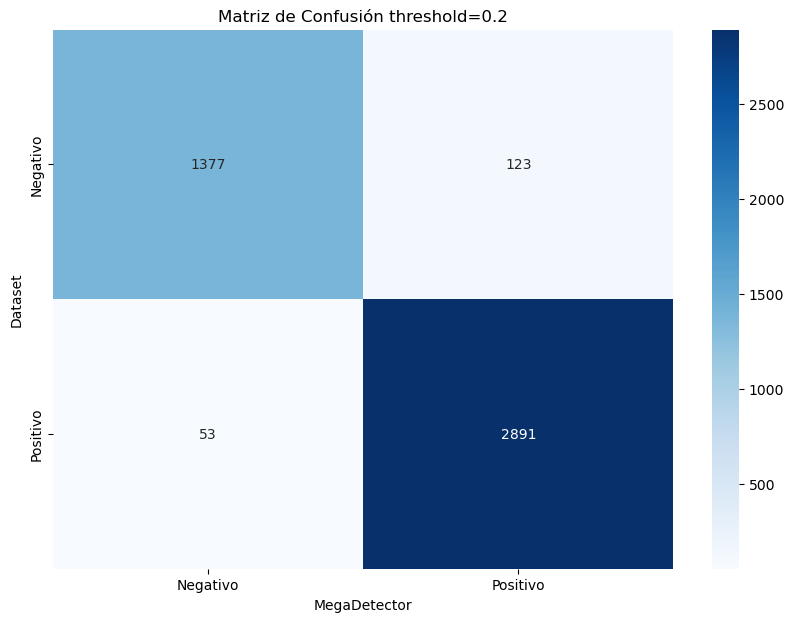

In [13]:
cm = confusion_matrix(
    predict_test["label"].astype(int), predict_test["detector_label"].astype(int)
)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negativo", "Positivo"],
    yticklabels=["Negativo", "Positivo"],
)
plt.xlabel("MegaDetector")
plt.ylabel("Dataset")
plt.title(f"Matriz de Confusión threshold={threshold}")
plt.show()


Random Classifier: ROC AUC=0.5
MobileNetV2 V1: ROC AUC=0.9500


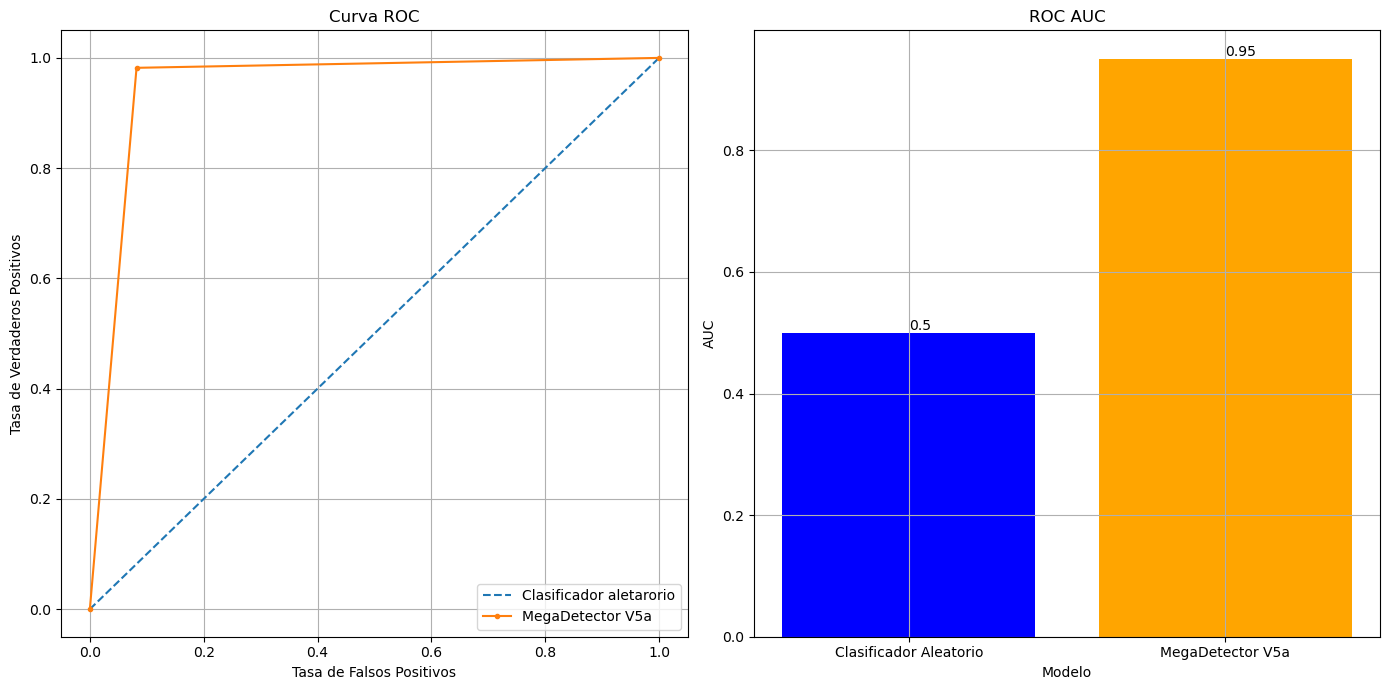

In [12]:
predict_test["label"] = predict_test["label"].astype(int)
predict_test["detector_label"] = predict_test["detector_label"].astype(int)

test_labels = predict_test["label"].values
predict_flatten = predict_test["detector_label"].values

random_flatten = np.zeros_like(test_labels)

random_auc = roc_auc_score(test_labels, random_flatten)
mobilenetv2_auc = roc_auc_score(test_labels, predict_flatten)

print("Random Classifier: ROC AUC=%.1f" % (random_auc))
print("MobileNetV2 V1: ROC AUC=%.4f" % (mobilenetv2_auc))

random_false_positive_rate, random_true_positive_rate, _ = roc_curve(
    test_labels, random_flatten
)
mobilenetv2_false_positive_rate, mobilenetv2_true_positive_rate, _ = roc_curve(
    test_labels, predict_flatten
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.plot(
    random_false_positive_rate,
    random_true_positive_rate,
    linestyle="--",
    label="Clasificador aletarorio",
)
ax1.plot(
    mobilenetv2_false_positive_rate,
    mobilenetv2_true_positive_rate,
    marker=".",
    label="MegaDetector V5a",
)
ax1.set_title("Curva ROC")
ax1.set_xlabel("Tasa de Falsos Positivos")
ax1.set_ylabel("Tasa de Verdaderos Positivos")
ax1.legend()
ax1.grid(True)

auc_labels = ["Clasificador Aleatorio", "MegaDetector V5a"]
auc_values = [random_auc, mobilenetv2_auc]
bars = ax2.bar(auc_labels, auc_values, color=["blue", "orange"])
ax2.set_title("ROC AUC")
ax2.set_xlabel("Modelo")
ax2.set_ylabel("AUC")
ax2.grid(True)

for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), va="bottom")

plt.tight_layout()
plt.show()
